In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import extract.data_loading as data_loading
import extract.compute_predictions as compute_predictions
import extract.compute_shap as compute_shap
import extract.compute_ism as compute_ism
import model.util as model_util
import model.profile_models as profile_models
import model.binary_models as binary_models
import plot.viz_sequence as viz_sequence
import torch
import numpy as np
import scipy.stats
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import json
import tqdm
tqdm.tqdm_notebook()  # It is necessary to call this before the tqdm.notebook submodule is available

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


|<bar/>| 0/? [00:00<?, ?it/s]

In [2]:
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

### Define paths for the model and data of interest

In [3]:
model_type = "binary"

In [4]:
# Shared paths/constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
data_base_path = "/users/amtseng/att_priors/data/processed/"
model_base_path = "/users/amtseng/att_priors/models/trained_models/%s/" % model_type
chrom_set = ["chr1"]
input_length = 1346 if model_type == "profile" else 1000
profile_length = 1000

In [ ]:
# SPI1
condition_name = "SPI1"
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/%s/config/SPI1/SPI1_training_paths.json" % model_type)
num_tasks = 4
num_strands = 2
controls = "matched"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithMatchedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "SPI1/27/model_ckpt_epoch_17.pt")
prior_model_path = os.path.join(model_base_path, "SPI1_prior/14/model_ckpt_epoch_18.pt")
peak_retention = "all"

In [ ]:
# GATA2
condition_name = "GATA2"
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/%s/config/GATA2/GATA2_training_paths.json" % model_type)
num_tasks = 3
num_strands = 2
controls = "matched"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithMatchedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "GATA2/6/model_ckpt_epoch_18.pt")
prior_model_path = os.path.join(model_base_path, "GATA2_prior/12/model_ckpt_epoch_19.pt")
peak_retention = "all"

In [5]:
# K562
files_spec_path = os.path.join(data_base_path, "ENCODE_DNase/%s/config/K562/K562_training_paths.json" % model_type)
condition_name = "K562"
num_tasks = 1
num_strands = 1
controls = "shared"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithSharedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "K562/18/model_ckpt_epoch_1.pt")
prior_model_path = os.path.join(model_base_path, "K562_prior/12/model_ckpt_epoch_6.pt")
peak_retention = "all"

In [ ]:
# BPNet
reference_fasta = "/users/amtseng/genomes/mm10.fasta"
chrom_sizes = "/users/amtseng/genomes/mm10.canon.chrom.sizes"
files_spec_path = os.path.join(data_base_path, "BPNet_ChIPseq/%s/config/BPNet_training_paths.json" % model_type)
condition_name = "BPNet"
num_tasks = 3
num_strands = 2
controls = "shared"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithSharedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "BPNet/20/model_ckpt_epoch_18.pt")
prior_model_path = os.path.join(model_base_path, "BPNet_prior/25/model_ckpt_epoch_17.pt")
peak_retention = "all"

### Import models

In [6]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
def restore_model(model_path):
    model = model_util.restore_model(model_class, model_path)
    model.eval()
    model = model.to(device)
    return model

In [8]:
# Import the model without priors
noprior_model = restore_model(noprior_model_path)

In [9]:
# Import the model with priors
prior_model = restore_model(prior_model_path)

### Data preparation
Create an input data loader, that maps coordinates or bin indices to data needed for the model. We'll also need to be able to determine the location of the summit for each coordinate. This is a little more tricky for binary models.

In [10]:
# Extract the set of peak BEDs; this is hacky way to do it
profile_files_spec_path = files_spec_path.replace("binary", "profile")
with open(profile_files_spec_path, "r") as f:
    spec = json.load(f)
    peak_bed_paths = spec["peak_beds"]

In [11]:
# Import the peak BEDs; in the meantime, add a column for the actual
# summit position, not just the offset with respect to the peak
peak_beds = []
for peak_bed_path in peak_bed_paths:
    table = pd.read_csv(
        peak_bed_path, sep="\t", header=None,  # Infer compression
        names=[
            "chrom", "peak_start", "peak_end", "name", "score",
            "strand", "signal", "pval", "qval", "summit_offset"
        ]
    )
    table = table[table["chrom"].isin(chrom_set)]
    table["summit_pos"] = table["peak_start"] + table["summit_offset"]
    peak_beds.append(table)

In [12]:
if model_type == "profile":
    input_func = data_loading.get_profile_input_func(
        files_spec_path, input_length, profile_length, reference_fasta
    )
    pos_examples = data_loading.get_positive_profile_coords(
        files_spec_path, chrom_set=chrom_set
    )
else:
    input_func = data_loading.get_binary_input_func(
        files_spec_path, input_length, reference_fasta
    )
    pos_examples = data_loading.get_positive_binary_bins(
        files_spec_path, chrom_set=chrom_set
    )

### Compute importances

In [13]:
# Pick a sample of 1000 random coordinates/bins
num_samples = 1000
rng = np.random.RandomState(20200318)
sample = pos_examples[rng.choice(len(pos_examples), size=num_samples, replace=False)]

In [14]:
# Get coordinates for the sample
if model_type == "profile":
    # For profile models, add a random jitter to avoid center-bias
    jitters = np.random.randint(-128, 128 + 1, size=len(sample))
    sample[:, 1] = sample[:, 1] + jitters
    sample[:, 2] = sample[:, 2] + jitters
    sample_coords = sample
else:
    sample_coords = input_func(sample)[2]

In [15]:
def compute_gradients(model, sample):
    """
    Given an array of N coordinates or bins, computes the input gradients
    for the model, returning an N x I x 4 array of gradient values and an
    N x I x 4 array of one-hot encoded sequence.
    """
    if model_type == "profile":
        results = compute_predictions.get_profile_model_predictions(                                              
            model, sample, num_tasks, input_func, controls=controls,                        
            return_losses=False, return_gradients=True, show_progress=True                                         
        )
    else:
        results = compute_predictions.get_binary_model_predictions(                                              
            model, sample, input_func,                      
            return_losses=False, return_gradients=True, show_progress=True                                         
        )
    return results["input_grads"], results["input_seqs"]

In [16]:
def compute_shap_scores(model, sample, batch_size=128):
    """
    Given an array of N coordinates or bins, computes the SHAP scores
    for the model, returning an N x I x 4 array of SHAP scores and an
    N x I x 4 array of one-hot encoded sequence.
    """
    num_samples = len(sample)
    num_batches = int(np.ceil(num_samples / batch_size))
    
    all_shap_scores = np.empty((num_samples, input_length, 4))
    all_one_hot_seqs = np.empty((num_samples, input_length, 4))
        
    if model_type == "profile":
        shap_explainer = compute_shap.create_profile_explainer(
            model, input_length, profile_length, num_tasks, num_strands, controls
        )
    else:
        shap_explainer = compute_shap.create_binary_explainer(
            model, input_length
        )

    for i in tqdm.notebook.trange(num_batches):
        batch_slice = slice(i * batch_size, (i + 1) * batch_size)
        batch = sample[batch_slice]

        if model_type == "profile":
            input_seqs, profiles = input_func(batch)
            shap_scores = shap_explainer(
                input_seqs, cont_profs=profiles[:, num_tasks:], hide_shap_output=True
            )
        else:
            input_seqs, _, _ = input_func(batch)
            shap_scores = shap_explainer(
                input_seqs, hide_shap_output=True
            )

        all_shap_scores[batch_slice] = shap_scores
        all_one_hot_seqs[batch_slice] = input_seqs
    return all_shap_scores, all_one_hot_seqs

In [17]:
# Compute the importance scores and 1-hot seqs
imp_type = ("DeepSHAP scores", "input gradients")[0]
imp_func = compute_shap_scores if imp_type == "DeepSHAP scores" else compute_gradients
noprior_scores, _ = imp_func(noprior_model, sample)
prior_scores, one_hot_seqs = imp_func(prior_model, sample)

In [18]:
# Pad the coordinates on both sides symmetrically to make them `input_length` 
centers = (sample_coords[:, 1] + sample_coords[:, 2]) // 2
starts = centers - (input_length // 2)
ends = starts + input_length
sample_coords[:, 1] = starts
sample_coords[:, 2] = ends

1299323
Without priors:


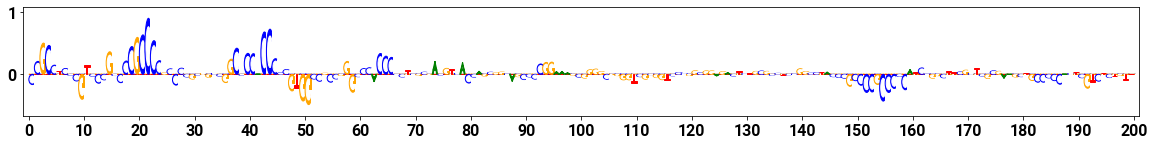

With priors:


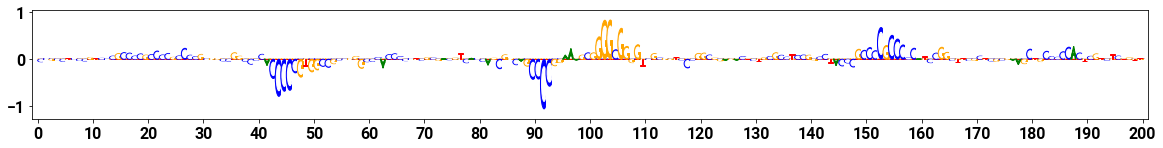

1254925
Without priors:


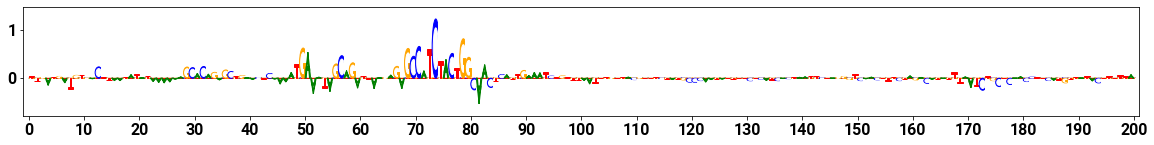

With priors:


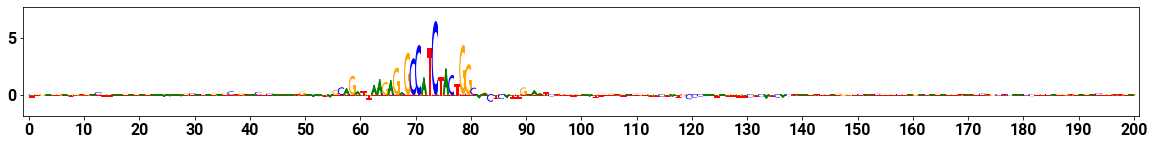

4742290
Without priors:


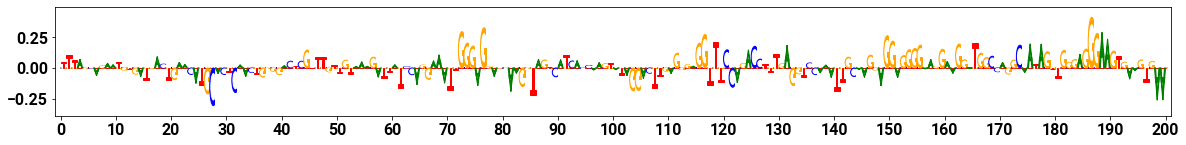

With priors:


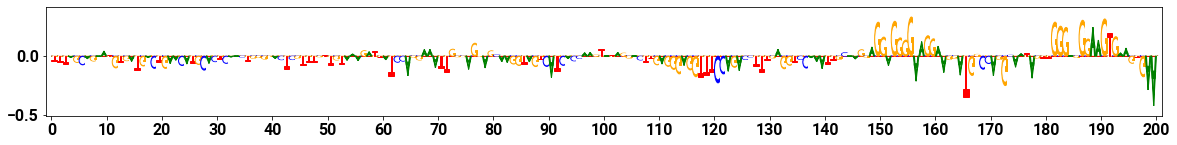

In [19]:
# Plot out a few examples
center_slice = slice(400, 600)
for i in np.random.choice(num_samples, size=3, replace=False):
    print(sample[i])
    print("=========================")
    print("Without priors:")
    viz_sequence.plot_weights(noprior_scores[i, center_slice] * one_hot_seqs[i, center_slice], subticks_frequency=10)
    print("With priors:")
    viz_sequence.plot_weights(prior_scores[i, center_slice] * one_hot_seqs[i, center_slice], subticks_frequency=10)

### Correlate importance to distance from summit

In [20]:
def get_summit_location(chrom, start, end):
    """
    Gets the locations of all summits that overlap this interval,
    relative to the given start and end.
    """
    summits = []
    for peak_bed in peak_beds:
        rows = peak_bed[
            (peak_bed["chrom"] == chrom) & \
            (peak_bed["summit_pos"] >= start) & \
            (peak_bed["summit_pos"] < end)
        ]
        if not len(rows):
            continue
        summits.extend(list(rows["summit_pos"] - start))
    return summits

In [21]:
def compute_summits(coords):
    """
    Given an N x 3 object array of coordinates, extracts the set of summit
    as offsets to the sample coordinates. Returns a list of N sublists, with
    each sublist being the set of overlapping summit offsets.
    """
    summits = []
    for coord in tqdm.notebook.tqdm(coords):
        summits.append(get_summit_location(coord[0], coord[1], coord[2]))
    return summits

In [22]:
def compute_windowed_distance_corr(scores, one_hot_seqs, summit_offsets, window_size=1):
    """
    Windowing by `window_size`, computes the total importance magnitude for the
    actual importance in each window, and correlates that to the distance from
    the summit. If there are multiple summits, then the closest one is used.
    Returns a NumPy array of correlation values, one for each sequence (where
    each correlation is done over the windows of the sequence).
    """
    num_samples = len(scores)
    corr_vals = np.empty(num_samples)
    for i in tqdm.notebook.trange(num_samples):
        score_track = np.sum(np.abs(scores[i] * one_hot_seqs[i]), axis=1)  # Actual importance
        score_track[score_track < 0] = 0
        
        offsets = summit_offsets[i]
        if not offsets:
            print("Warning: found a sequence with no captured summit")
            corr_vals[i] = 0
            continue
        num_windows = len(score_track) - window_size + 1
        
        # Compute distances to summits
        distances = np.empty((len(offsets), num_windows))
        window_locs = np.arange(num_windows) + ((len(score_track) - num_windows) / 2)
        for j, offset in enumerate(offsets):
            distances[j] = np.abs(window_locs - offset)
        closest_distances = np.amin(distances, axis=0)
        
        # Compute sum of importance in each window
        importances = np.empty(num_windows)
        for j in range(num_windows):
            importances[j] = np.sum(score_track[j : j + window_size])
        
        corr_vals[i] = scipy.stats.spearmanr(importances, closest_distances)[0]
    return corr_vals

In [23]:
window_size = 1

In [24]:
summit_offsets = compute_summits(sample_coords)
noprior_corrs = compute_windowed_distance_corr(noprior_scores, one_hot_seqs, summit_offsets, window_size=window_size)
prior_corrs = compute_windowed_distance_corr(prior_scores, one_hot_seqs, summit_offsets, window_size=window_size)

Average correlation without priors: -0.334929
Average correlation with priors: -0.359755
One-sided Wilcoxon test: w = 321342.000000, p = 0.000000


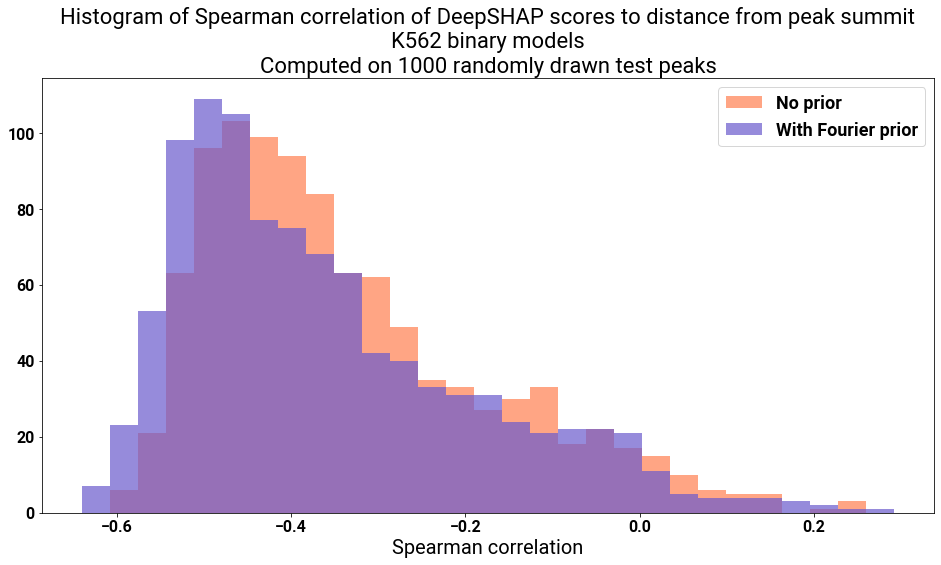

In [25]:
bin_num = 30
all_vals = np.concatenate([noprior_corrs, prior_corrs])
bins = np.linspace(np.min(all_vals), np.max(all_vals), bin_num)
fig, ax = plt.subplots(figsize=(16, 8))
ax.hist(noprior_corrs, bins=bins, color="coral", label="No prior", alpha=0.7)
ax.hist(prior_corrs, bins=bins, color="slateblue", label="With Fourier prior", alpha=0.7)
plt.legend()
plt.title(
    ("Histogram of Spearman correlation of %s to distance from peak summit" % imp_type) +
    ("\n%s %s models" % (condition_name, model_type)) +
    ("\nComputed on %d randomly drawn test peaks" % num_samples)
)
plt.xlabel("Spearman correlation")

print("Average correlation without priors: %f" % np.mean(noprior_corrs))
print("Average correlation with priors: %f" % np.mean(prior_corrs))
w, p = scipy.stats.wilcoxon(noprior_corrs, prior_corrs, alternative="greater")
print("One-sided Wilcoxon test: w = %f, p = %f" % (w, p))

Text(0, 0.5, 'Spearman correlation with Fourier prior')

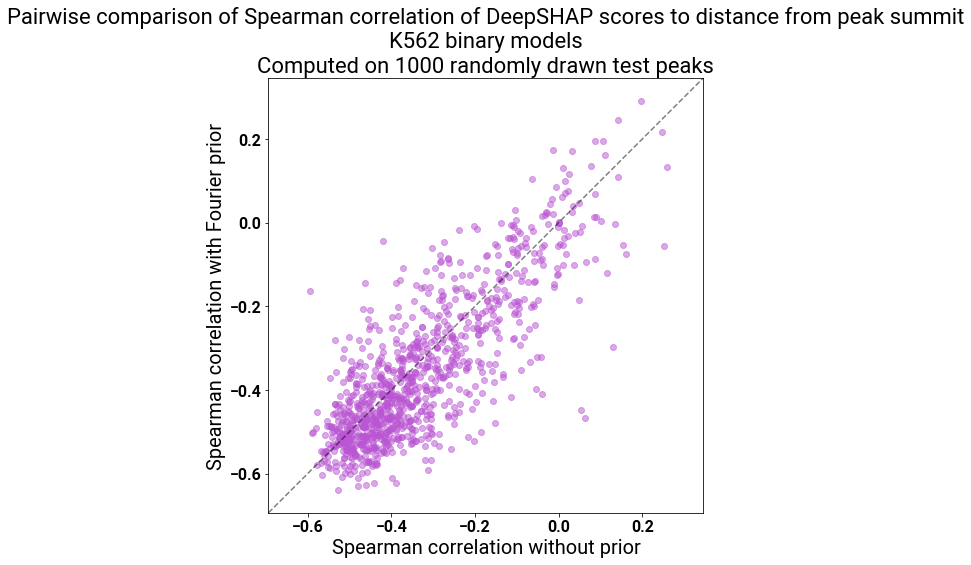

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(noprior_corrs, prior_corrs, color="mediumorchid", alpha=0.5)
plt.title(
    ("Pairwise comparison of Spearman correlation of %s to distance from peak summit" % imp_type) +
    ("\n%s %s models" % (condition_name, model_type)) +
    ("\nComputed on %d randomly drawn test peaks" % num_samples)
)
limits = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(limits, limits, "--", alpha=0.5, color="black")
ax.set_aspect("equal")
ax.set_xlim(limits)
ax.set_ylim(limits)
plt.xlabel("Spearman correlation without prior")
plt.ylabel("Spearman correlation with Fourier prior")

### Ranked enrichment of peak overlap and summit closeness with importance

In [27]:
def normed_rank_enrichment(ordered_mask):
    """
    From a binary mask array (in order from best to worst thresholds), computes
    the rank enrichment at each threshold. Specifically, this computes a
    normalized CDF of how many 1s are seen in the first k instances.
    """
    cdf = np.cumsum(ordered_mask)
    # To normalize, divide by the expectation if there all 1s were spread
    # out evenly across the instances
    expectation = np.sum(ordered_mask) / len(ordered_mask) * np.arange(1, len(cdf) + 1)
    return cdf / expectation

In [28]:
def compute_single_peak_overlap_mask(chrom, start, end):
    """
    Given a coordinate, returns a boolean mask for that coordinate
    for which bases lie within a peak.
    """
    mask = np.zeros(end - start, dtype=bool)
    for peak_bed in peak_beds:
        rows = peak_bed[
            (peak_bed["chrom"] == chrom) & \
            (peak_bed["peak_start"] <= end) & \
            (start <= peak_bed["peak_end"])
        ]
        intervals = rows[["peak_start", "peak_end"]].values - start
        for interval in intervals:
            mask[interval[0]:interval[1]] = True
    return mask

def compute_peak_overlap_mask(coords):
    """
    Given an N x 3 object array of coordinates, extracts a boolean mask
    denoting which locations in each sample overlap a peak.
    Returns an N x I boolean array, where each subarray is a boolean mask for
    which bases in that coordinate lie within a peak.
    """
    masks = []
    for coord in tqdm.notebook.tqdm(coords):
        masks.append(compute_single_peak_overlap_mask(coord[0], coord[1], coord[2]))
    return np.stack(masks, axis=0)

In [29]:
def compute_windowed_peak_overlap_mask(scores, one_hot_seqs, seq_peak_masks, window_size=10):
    """
    Windowing by `window_size`, computes the total importance magnitude for the
    actual importance in each window, and identifies which windows overlap a peak.
    Returns a boolean NumPy array denoting which windows overlap a peak, sorted in
    descending order of window importance, and the indices of each window.
    This requires a mask of whether or not each base in each input sequence overlaps
    a peak, computed by `compute_peak_overlap_mask`.
    """
    num_samples = len(scores)
    all_window_imps, all_peak_masks = [], []
    all_window_inds = []
    for i in tqdm.notebook.trange(num_samples):
        score_track = np.sum(np.abs(scores[i] * one_hot_seqs[i]), axis=1)  # Actual importance
        num_windows = len(score_track) - window_size + 1
        
        # Compute windowed peak mask
        window_locs = np.arange(num_windows) + ((len(score_track) - num_windows) / 2)
        windowed_peak_mask = seq_peak_masks[i][window_locs.astype(int)]
        
        # Compute sum of importance in each window
        importances = np.empty(num_windows)
        for j in range(num_windows):
            importances[j] = np.sum(score_track[j : j + window_size])
            all_window_inds.append([i, j])
        
        all_window_imps.append(importances)
        all_peak_masks.append(windowed_peak_mask)
    
    all_window_imps, all_peak_masks = np.concatenate(all_window_imps), np.concatenate(all_peak_masks)
    all_window_inds = np.stack(all_window_inds)
    sorted_inds = np.flip(np.argsort(all_window_imps))
    return all_peak_masks[sorted_inds], all_window_inds[sorted_inds], all_window_imps[sorted_inds]

In [30]:
peak_masks = compute_peak_overlap_mask(sample_coords)
noprior_peak_mask, noprior_windows, noprior_window_imps = compute_windowed_peak_overlap_mask(noprior_scores, one_hot_seqs, peak_masks, window_size=window_size)
prior_peak_mask, prior_windows, prior_window_imps = compute_windowed_peak_overlap_mask(prior_scores, one_hot_seqs, peak_masks, window_size=window_size)
noprior_peak_cdf = normed_rank_enrichment(noprior_peak_mask)
prior_peak_cdf = normed_rank_enrichment(prior_peak_mask)

In [31]:
# def show(indexes):
#     i, j = indexes
#     print(j)
#     print(sample_coords[i])
#     plt.figure(figsize=(20, 3))
#     plt.plot(np.sum(prior_scores[i] * one_hot_seqs[i], axis=1))
#     plt.show()
#     viz_sequence.plot_weights(prior_scores[i][j - 10: j + 10])
#     viz_sequence.plot_weights((prior_scores[i] * one_hot_seqs[i])[j - 10: j + 10])
    
#     plt.figure(figsize=(20, 3))
#     plt.plot(np.sum(noprior_scores[i] * one_hot_seqs[i], axis=1))
#     plt.show()
#     viz_sequence.plot_weights(noprior_scores[i][j - 10: j + 10])
#     viz_sequence.plot_weights((noprior_scores[i] * one_hot_seqs[i])[j - 10: j + 10])

In [32]:
# inds = np.where(~prior_peak_mask[:1000])[0]
# print(inds)
# show(prior_windows[inds[0]])

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


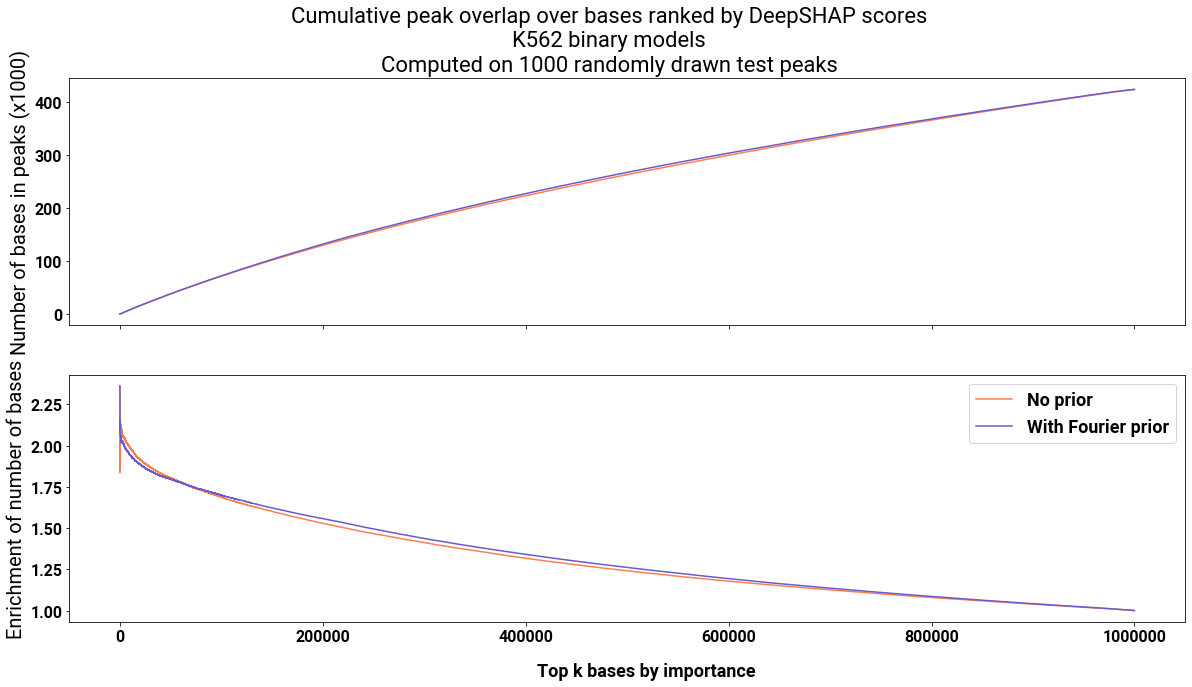

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
title = "Cumulative peak overlap over bases ranked by %s" % imp_type
title += "\n%s %s models" % (condition_name, model_type)
title += "\nComputed on %d randomly drawn test peaks" % num_samples
fig.suptitle(title)
ax[0].plot(np.cumsum(noprior_peak_mask), label="No prior", color="coral")
ax[0].plot(np.cumsum(prior_peak_mask), label="With Fourier prior", color="slateblue")
ax[0].set_ylabel("Number of bases in peaks (x1000)")
ax[0].set_yticklabels((ax[0].get_yticks() / 1000).astype(int))
ax[1].plot(noprior_peak_cdf, label="No prior", color="coral")
ax[1].plot(prior_peak_cdf, label="With Fourier prior", color="slateblue")
ax[1].set_ylabel("Enrichment of number of bases")
fig.text(0.45, 0.05, "Top k bases by importance", fontsize=18)
plt.legend()

In [34]:
noprior_prs = sklearn.metrics.precision_recall_curve(
    np.flip(noprior_peak_mask.astype(int)),
    np.flip(noprior_window_imps / np.max(noprior_window_imps))
)
prior_prs = sklearn.metrics.precision_recall_curve(
    np.flip(prior_peak_mask.astype(int)),
    np.flip(prior_window_imps / np.max(prior_window_imps))
)

auPRC without priors: 0.587040
auPRC with priors: 0.594027


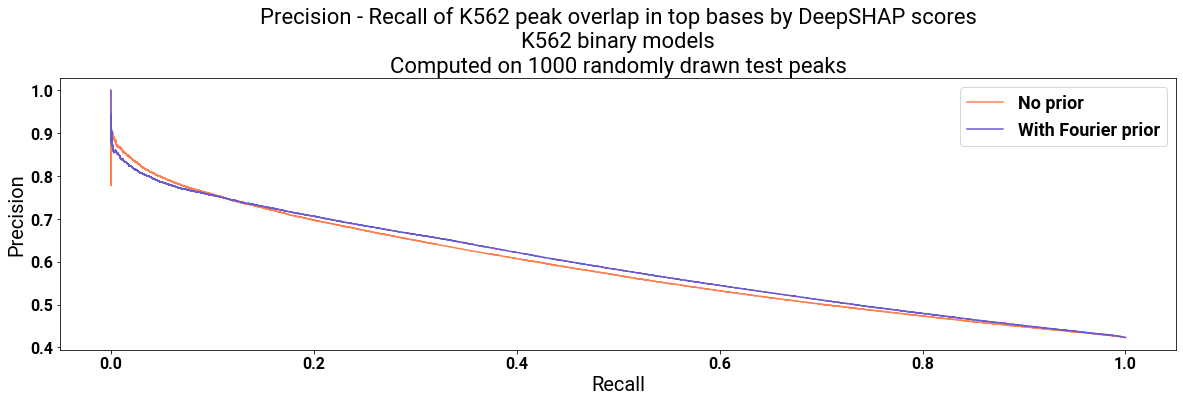

In [35]:
fig, ax = plt.subplots(figsize=(20, 5))
title = "Precision - Recall of %s peak overlap in top bases by %s" % (condition_name, imp_type)
title += "\n%s %s models" % (condition_name, model_type)
title += "\nComputed on %d randomly drawn test peaks" % num_samples
plt.title(title)
plt.plot(noprior_prs[1][:-1], noprior_prs[0][:-1], color="coral", label="No prior")
plt.plot(prior_prs[1][:-1], prior_prs[0][:-1], color="slateblue", label="With Fourier prior")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

print("auPRC without priors: %f" % (sklearn.metrics.auc(noprior_prs[1][:-1], noprior_prs[0][:-1])))
print("auPRC with priors: %f" % sklearn.metrics.auc(prior_prs[1][:-1], prior_prs[0][:-1]))